## Trio不同方法计算比较及阈值确定

In [1]:
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
ldak_id = 'demo_data/trio_data/ldak5_nw.grm.id.txt'
ldak_mat = 'demo_data/trio_data/ldak5_nw.grm.raw.txt'
plink_cov_id = 'demo_data/trio_data/make_cal_cov.rel.id.txt'
plink_cov_mat = 'demo_data/trio_data/make_cal_cov.rel.txt'
plink_ibc2_id = 'demo_data/trio_data/make_cal_ibc2.rel.id.txt'
plink_ibc2_mat = 'demo_data/trio_data/make_cal_ibc2.rel.txt'
plink_ibc3_id = 'demo_data/trio_data/make_cal_ibc3.rel.id.txt'
plink_ibc3_mat = 'demo_data/trio_data/make_cal_ibc3.rel.txt'

In [42]:
## 读取数据
def get_dataFrame(id_file,mat_file,sep='\t'):
    ids=[]
    with open(id_file,'r') as f:
        line = f.readline()
        while line:
            cells = line.strip('\n').split('_')
            ids.append(cells[0])
            line=f.readline()
    pd_data = pd.read_csv(mat_file,sep=sep,header=None)
    pd_data.dropna(axis='columns',inplace=True)
    pd_data.dropna(inplace=True)
    pd_data.columns=ids
    pd_data['sample'] = ids
    pd_data.set_index('sample',inplace=True)
    return pd_data

def get_diag(pd_data):
    if pd_data.shape[0] == pd_data.shape[1]:
        diag=[pd_data.iloc[i,i] for i in range(pd_data.shape[0])]
    else:
        raise ValueError('方阵才能取diag,shape={}'.format(pd_data.shape))
    return diag

In [56]:
ldak_pd = get_dataFrame(ldak_id,ldak_mat,sep=' ')
plink_cov_pd = get_dataFrame(plink_cov_id,plink_cov_mat)
plink_ibc2_pd = get_dataFrame(plink_ibc2_id,plink_ibc2_mat)
plink_ibc3_pd = get_dataFrame(plink_ibc3_id,plink_ibc3_mat)

# print(ldak_pd.head())
# print(plink_cov_pd.head())
# print(plink_ibc2_pd.head())
# print(plink_ibc3_pd.head())

In [48]:
ldak_diag = get_diag(ldak_pd)
cov_diag = get_diag(plink_cov_pd)
ibc2_diag = get_diag(plink_ibc2_pd)
ibc3_diag = get_diag(plink_ibc3_pd)
diag_pd = pd.DataFrame({'ldak':ldak_diag,
                        'cov':cov_diag,
                        'ibc2':ibc2_diag,
                        'ibc3':ibc3_diag})

all_pd = pd.DataFrame({'ldak':ldak_pd.stack(),
                        'cov':plink_cov_pd.stack(),
                        'ibc2':plink_ibc2_pd.stack(),
                        'ibc3':plink_ibc3_pd.stack()})


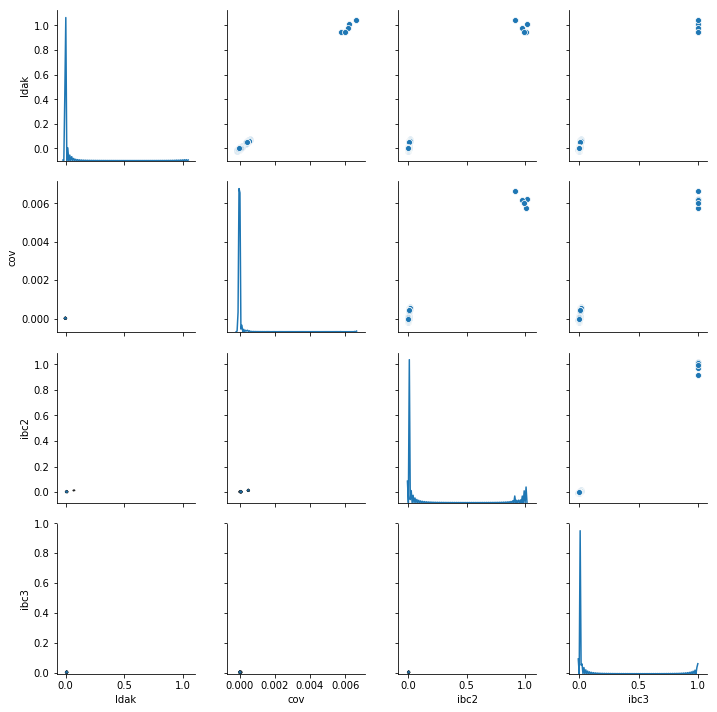

In [55]:

g = sns.PairGrid(all_pd.sample(5000), diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot)

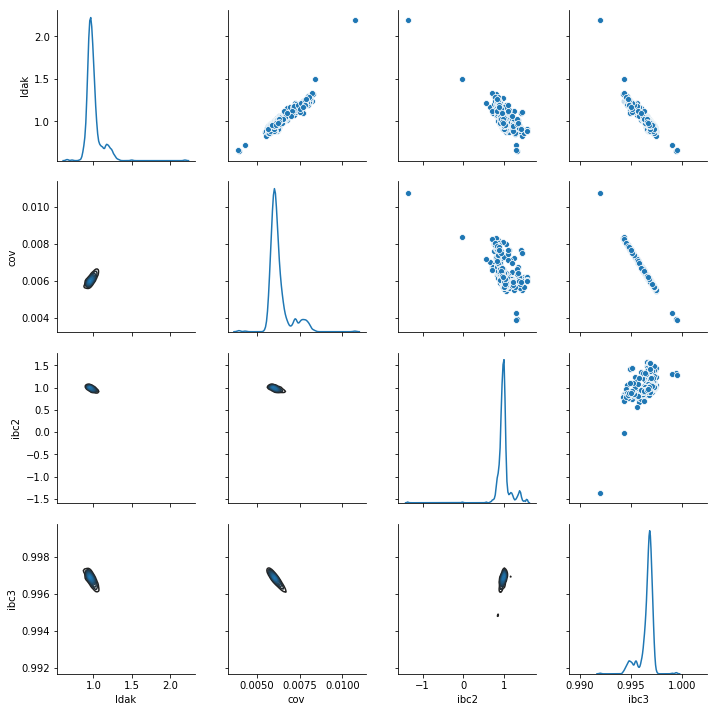

In [50]:
g = sns.PairGrid(diag_pd, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot)

In [80]:
diag_de=diag_pd.describe()

ldak_mean = ldak_pd.stack().mean()
ldak_std = ldak_pd.stack().std()
ldak_mean_p =  diag_de['ldak']['mean']
ldak_std_p = diag_de['ldak']['std']

ibc3_mean = plink_ibc3_pd.stack().mean()
ibc3_std =plink_ibc3_pd.stack().std()
ibc3_mean_p = diag_de['ibc3']['mean']
ibc3_std_p = diag_de['ibc3']['std']

state=pd.DataFrame([['ldak',ldak_mean,ldak_std,ldak_mean_p,ldak_std_p],
                    ['ibc3',ibc3_mean,ibc3_std,ibc3_mean_p,ibc3_std_p]],columns=['type','mean','std','p_mean','p_std'])
state.set_index('type',inplace=True)

              mean       std    p_mean     p_std
type                                            
ldak -5.081571e-10  0.038108  1.000000  0.099347
ibc3 -3.119551e-11  0.036259  0.996564  0.000687


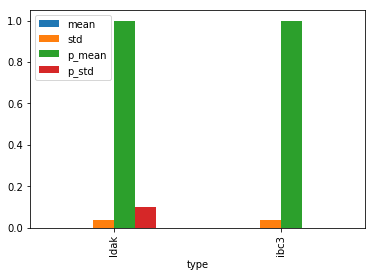

In [83]:
print(state)
state.plot.bar()